# Artificial Neural Network

## Implementation

### Imports

In [1]:
%matplotlib inline
import scipy.special
import matplotlib.pyplot as plt
import numpy
import pandas
import random
import os

### Global variables

In [2]:
input_nodes = 784
hidden_nodes = 400
output_nodes = 10

# initial values
learning_rate = 0.2
batch_size = 40
epochs = 100

### Neural network class

In [3]:
class neuralNetwork:
	"""Artificial Neural Network classifier.

	Parameters
	------------
	lr : float
		Learning rate (between 0.0 and 1.0)
	ep : int
		Number of epochs for training the network towards achieving convergence
	batch_size : int
		Size of the training batch to be used when calculating the gradient descent.
		batch_size = 0 standard gradient descent
		batch_size > 0 stochastic gradient descent

	inodes : int
		Number of input nodes which is normally the number of features in an instance.
	hnodes : int
		Number of hidden nodes in the net.
	onodes : int
		Number of output nodes in the net.

	Attributes
	-----------
	wih : 2d-array
		Input2Hidden node weights after fitting
	who : 2d-array
		Hidden2Output node weights after fitting
	E : list
		Sum-of-squares error value in each epoch.

	Results : list
		Target and predicted class labels for the test data.

	Functions
	---------
	activation_function : float (between 1 and -1)
		implments the sigmoid function which squashes the node input
	"""

	def __init__(self, inputnodes = 784, hiddennodes = 200, outputnodes = 10, learningrate = 0.2, batch_size = 40, epochs = 100):
		self.inodes = inputnodes
		self.hnodes = hiddennodes
		self.onodes = outputnodes

		#link weight matrices, wih (input to hidden) and who (hidden to output)
		#a weight on link from node i to node j is w_ij

		#Draw random samples from a normal (Gaussian) distribution centered around 0.
		#numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want)
		#scale is usually set to the standard deviation which is related to the number of incoming links i.e.
		#1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
		#We have set 0 as the centre of the guassian dist.
		# size is set to the dimensions of the number of hnodes, inodes and onodes
		self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
		self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))

		#set the learning rate
		self.lr = learningrate

		#set the batch size
		self.bs = batch_size

		#set the number of epochs
		self.ep = epochs

		#store errors at each epoch
		self.E = []

		#store results from testing the model
		#keep track of the network performance on each test instance
		self.results = []

		#define the activation function here
		#specify the sigmoid squashing function. Here expit() provides the sigmoid function.
		#lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
		self.activation_function = lambda x: scipy.special.expit(x)

		pass

	def batch_input(self, input_list):
		"""Yield consecutive batches of the specified size from the input list."""
		for i in range(0, len(input_list), self.bs):
			yield input_list[i:i + self.bs]

	#train the neural net
	def train(self, train_inputs):
		"""Training the neural net.
			This includes the forward pass ; error computation;
			backprop of the error ; calculation of gradients and updating the weights.

			Parameters
			----------
			train_inputs : {array-like}, shape = [n_instances, n_features]
			Training vectors, where n_instances is the number of training instances and
			n_features is the number of features.
			Note this contains all features including the class feature which is in first position

			Returns
			-------
			self : object
		"""

		for e in range(self.ep):
			print("Training epoch#: ", e)
			sum_error = 0.0
			for batch in self.batch_input(train_inputs):
				#creating variables to store the gradients
				delta_who = 0
				delta_wih = 0

				for instance in batch:

					# split it by the commas
					all_values = instance.split(',')
					# scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
					# divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
					# multiply by 0.99 to bring them into the range 0.0 - 0.99.
					# add 0.01 to shift them up to the desired range 0.01 - 1.
					inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

					#create the target output values for each instance so that we can use it with the neural net
					#note we need 10 nodes where each represents one of the digits
					targets = numpy.zeros(output_nodes) + 0.01 #all initialised to 0.01
					#all_value[0] has the target class label for this instance
					targets[int(instance[0])] = 0.99

					#convert  inputs list to 2d array
					inputs = numpy.array(inputs,  ndmin = 2).T
					targets = numpy.array(targets, ndmin = 2).T

					#calculate signals into hidden layer
					hidden_inputs = numpy.dot(self.wih, inputs)
					#calculate the signals emerging from the hidden layer
					hidden_outputs = self.activation_function(hidden_inputs)

					#calculate signals into final output layer
					final_inputs = numpy.dot(self.who, hidden_outputs)
					#calculate the signals emerging from final output layer
					final_outputs = self.activation_function(final_inputs)

					#to calculate the error we need to compute the element wise diff between target and actual
					output_errors = targets - final_outputs
					#Next distribute the error to the hidden layer such that hidden layer error
					#is the output_errors, split by weights, recombined at hidden nodes
					hidden_errors = numpy.dot(self.who.T, output_errors)

					## for each instance accumilate the gradients from each instance
					## delta_who are the gradients between hidden and output weights
					## delta_wih are the gradients between input and hidden weights
					delta_who += numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
					delta_wih += numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

					sum_error += numpy.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance

				pass

				# update the weights by multiplying the gradient with the learning rate
				# note that the deltas are divided by batch size to obtain the average gradient according to the given batch
				# obviously if batch size = 1 then we dont need to bother with an average
				self.who += self.lr * (delta_who / self.bs)
				self.wih += self.lr * (delta_wih / self.bs)
			pass # batch
			self.E.append(numpy.asfarray(sum_error).flatten())
			print("errors (SSE): ", self.E[-1])
		pass # epoch

	#query the neural net
	def query(self, inputs_list):
		#convert inputs_list to a 2d array
		#print(numpy.matrix(inputs_list))
		#inputs_list [[ 1.   0.5 -1.5]]
		inputs = numpy.array(inputs_list, ndmin = 2).T
		#once converted it appears as follows
		#[[ 1. ]
		# [ 0.5]
		# [-1.5]]
		#print(numpy.matrix(inputs))

		#propogate input into hidden layer. This is the start of the forward pass
		hidden_inputs = numpy.dot(self.wih, inputs)

		#squash the content in the hidden node using the sigmoid function (value between 1, -1)
		hidden_outputs = self.activation_function(hidden_inputs)

		#propagate into output layer and the apply the squashing sigmoid function
		final_inputs = numpy.dot(self.who, hidden_outputs)

		final_outputs = self.activation_function(final_inputs)
		return final_outputs

	#iterate through all the test data to calculate model accuracy
	def test(self, test_inputs):
		self.results = []

		#go through each test instances
		for instance in test_inputs:
			all_values = instance.split(',') # extract the input feature values for the instance

			target_label = int(all_values[0]) # get the target class for the instance

			#scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
			inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

			#query the network with test inputs
			#note this returns 10 output values ; of which the index of the highest value
			# is the networks predicted class label
			outputs = self.query(inputs)

			#get the index of the highest output node as this corresponds to the predicted class
			predict_label = numpy.argmax(outputs) #this is the class predicted by the ANN

			self.results.append([predict_label, target_label])
			#compute network error
			#if (predict_label == target_label):
			#	self.results.append(1)
			#else:
			#	self.results.append(0)
			pass
		pass
		self.results = numpy.asfarray(self.results) # flatten results to avoid nested arrays

## MNIST dataset

### Loading files

In [4]:
mnist_train_file = open("../datasets/mnist_train.csv", 'r')
mnist_train_list = mnist_train_file.readlines() 
mnist_train_file.close() 
print("train set size: ", len(mnist_train_list))

mnist_test_file = open("../datasets/mnist_test.csv", 'r')
mnist_test_list = mnist_test_file.readlines()
mnist_test_file.close()
print("test set size: ", len(mnist_test_list))

# quick run
mnist_train_list = numpy.random.choice(mnist_train_list, 1000, replace = False)
mnist_test_list = numpy.random.choice(mnist_test_list, 1000, replace = False)

train set size:  60000
test set size:  10000


### Normalization

In [5]:
normalized_data = []
"""
for entry in mnist_train_list:
	all_values = entry.split(',')
	normalized_data.append((numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01)
mnist_train_list = normalized_data
print(normalized_data[0])
"""

"\nfor entry in mnist_train_list:\n\tall_values = entry.split(',')\n\tnormalized_data.append((numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01)\nmnist_train_list = normalized_data\nprint(normalized_data[0])\n"

#### Epochs

##### Training

In [6]:
ann_epoch_numbers_list = []
epoch_numbers = [1, 10, 100, 200, 300]

for epoch_number in epoch_numbers:
    print("Number of epochs : ", epoch_number)
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epoch_number)
    n.train(mnist_train_list)
    ann_epoch_numbers_list.append(n)

Number of epochs :  1
Training epoch#:  0
errors (SSE):  [638.84431313]
Number of epochs :  10
Training epoch#:  0
errors (SSE):  [742.70999774]
Training epoch#:  1
errors (SSE):  [317.66976716]
Training epoch#:  2
errors (SSE):  [253.9697914]
Training epoch#:  3
errors (SSE):  [221.1016366]
Training epoch#:  4
errors (SSE):  [199.86066287]
Training epoch#:  5
errors (SSE):  [184.62796603]
Training epoch#:  6
errors (SSE):  [172.96904941]
Training epoch#:  7
errors (SSE):  [163.61723705]
Training epoch#:  8
errors (SSE):  [155.84426622]
Training epoch#:  9
errors (SSE):  [149.20234353]
Number of epochs :  100
Training epoch#:  0
errors (SSE):  [713.32933604]
Training epoch#:  1
errors (SSE):  [304.67647341]
Training epoch#:  2
errors (SSE):  [243.40998584]
Training epoch#:  3
errors (SSE):  [213.25523066]
Training epoch#:  4
errors (SSE):  [194.01059495]
Training epoch#:  5
errors (SSE):  [180.12537981]
Training epoch#:  6
errors (SSE):  [169.34805788]
Training epoch#:  7
errors (SSE):

errors (SSE):  [59.83534472]
Training epoch#:  52
errors (SSE):  [58.94238653]
Training epoch#:  53
errors (SSE):  [58.07043891]
Training epoch#:  54
errors (SSE):  [57.21904034]
Training epoch#:  55
errors (SSE):  [56.38764174]
Training epoch#:  56
errors (SSE):  [55.57562003]
Training epoch#:  57
errors (SSE):  [54.78229498]
Training epoch#:  58
errors (SSE):  [54.00694662]
Training epoch#:  59
errors (SSE):  [53.24883206]
Training epoch#:  60
errors (SSE):  [52.50720114]
Training epoch#:  61
errors (SSE):  [51.78131088]
Training epoch#:  62
errors (SSE):  [51.07043861]
Training epoch#:  63
errors (SSE):  [50.37389388]
Training epoch#:  64
errors (SSE):  [49.69102854]
Training epoch#:  65
errors (SSE):  [49.02124467]
Training epoch#:  66
errors (SSE):  [48.3639998]
Training epoch#:  67
errors (SSE):  [47.71880896]
Training epoch#:  68
errors (SSE):  [47.08524348]
Training epoch#:  69
errors (SSE):  [46.46292668]
Training epoch#:  70
errors (SSE):  [45.85152722]
Training epoch#:  71
e

errors (SSE):  [127.47291922]
Training epoch#:  14
errors (SSE):  [123.53892937]
Training epoch#:  15
errors (SSE):  [119.90591726]
Training epoch#:  16
errors (SSE):  [116.53502187]
Training epoch#:  17
errors (SSE):  [113.39430966]
Training epoch#:  18
errors (SSE):  [110.45714655]
Training epoch#:  19
errors (SSE):  [107.70106111]
Training epoch#:  20
errors (SSE):  [105.10693101]
Training epoch#:  21
errors (SSE):  [102.65838603]
Training epoch#:  22
errors (SSE):  [100.3413578]
Training epoch#:  23
errors (SSE):  [98.14372642]
Training epoch#:  24
errors (SSE):  [96.05502415]
Training epoch#:  25
errors (SSE):  [94.06616589]
Training epoch#:  26
errors (SSE):  [92.16919191]
Training epoch#:  27
errors (SSE):  [90.35702798]
Training epoch#:  28
errors (SSE):  [88.62328016]
Training epoch#:  29
errors (SSE):  [86.96208065]
Training epoch#:  30
errors (SSE):  [85.36798859]
Training epoch#:  31
errors (SSE):  [83.83593741]
Training epoch#:  32
errors (SSE):  [82.36121311]
Training epo

errors (SSE):  [15.08915532]
Training epoch#:  177
errors (SSE):  [14.94834556]
Training epoch#:  178
errors (SSE):  [14.80919131]
Training epoch#:  179
errors (SSE):  [14.67167021]
Training epoch#:  180
errors (SSE):  [14.53576017]
Training epoch#:  181
errors (SSE):  [14.40143936]
Training epoch#:  182
errors (SSE):  [14.26868623]
Training epoch#:  183
errors (SSE):  [14.13747953]
Training epoch#:  184
errors (SSE):  [14.00779827]
Training epoch#:  185
errors (SSE):  [13.87962176]
Training epoch#:  186
errors (SSE):  [13.75292961]
Training epoch#:  187
errors (SSE):  [13.62770169]
Training epoch#:  188
errors (SSE):  [13.50391821]
Training epoch#:  189
errors (SSE):  [13.38155965]
Training epoch#:  190
errors (SSE):  [13.26060681]
Training epoch#:  191
errors (SSE):  [13.14104078]
Training epoch#:  192
errors (SSE):  [13.02284297]
Training epoch#:  193
errors (SSE):  [12.90599511]
Training epoch#:  194
errors (SSE):  [12.79047925]
Training epoch#:  195
errors (SSE):  [12.67627775]
Tr

##### Compute the accuracy of the neural networks

In [7]:
epoch_numbers_model_results = []
for model in ann_epoch_numbers_list: 
    correct = 0
    model.test(mnist_test_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    epoch_numbers_model_results.append(100 * (correct / len(model.results)))
    pass
pass

##### Show the accuracy of the neural networks

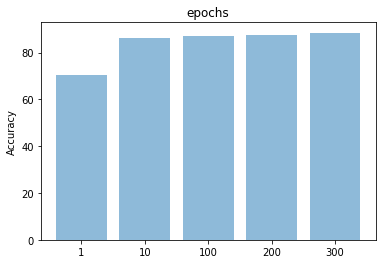

In [8]:
objects = epoch_numbers
y_pos = numpy.arange(len(objects))
performance = epoch_numbers_model_results

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('epochs')

fig_epoch_numbers = plt.gcf()
plt.show()
fig_epoch_numbers.savefig('../images/ann_epoch_numbers_mnist.png', dpi = 300)

#### Batch size

##### Training

In [9]:
ann_batch_sizes_list = []
batch_sizes = [1, 10, 100, 500, len(mnist_train_list)]

for batch_size in batch_sizes:
    print("Batch_sizes : ", batch_size)
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)
    n.train(mnist_train_list)
    ann_batch_sizes_list.append(n)

Batch_sizes :  1
Training epoch#:  0
errors (SSE):  [440.74297659]
Training epoch#:  1
errors (SSE):  [180.01678644]
Training epoch#:  2
errors (SSE):  [100.63314457]
Training epoch#:  3
errors (SSE):  [56.93000648]
Training epoch#:  4
errors (SSE):  [34.99019057]
Training epoch#:  5
errors (SSE):  [22.11192984]
Training epoch#:  6
errors (SSE):  [14.48021986]
Training epoch#:  7
errors (SSE):  [10.07945553]
Training epoch#:  8
errors (SSE):  [7.5676854]
Training epoch#:  9
errors (SSE):  [6.00540763]
Training epoch#:  10
errors (SSE):  [4.93773904]
Training epoch#:  11
errors (SSE):  [4.16976518]
Training epoch#:  12
errors (SSE):  [3.59253333]
Training epoch#:  13
errors (SSE):  [3.14253225]
Training epoch#:  14
errors (SSE):  [2.78140807]
Training epoch#:  15
errors (SSE):  [2.48518647]
Training epoch#:  16
errors (SSE):  [2.23869702]
Training epoch#:  17
errors (SSE):  [2.03160149]
Training epoch#:  18
errors (SSE):  [1.85607188]
Training epoch#:  19
errors (SSE):  [1.70588142]
Tra

errors (SSE):  [5.52447494]
Training epoch#:  67
errors (SSE):  [5.37617357]
Training epoch#:  68
errors (SSE):  [5.23402236]
Training epoch#:  69
errors (SSE):  [5.09770888]
Training epoch#:  70
errors (SSE):  [4.96693756]
Training epoch#:  71
errors (SSE):  [4.84142887]
Training epoch#:  72
errors (SSE):  [4.7209186]
Training epoch#:  73
errors (SSE):  [4.60515716]
Training epoch#:  74
errors (SSE):  [4.49390898]
Training epoch#:  75
errors (SSE):  [4.38695187]
Training epoch#:  76
errors (SSE):  [4.28407635]
Training epoch#:  77
errors (SSE):  [4.18508505]
Training epoch#:  78
errors (SSE):  [4.08979195]
Training epoch#:  79
errors (SSE):  [3.99802181]
Training epoch#:  80
errors (SSE):  [3.90960938]
Training epoch#:  81
errors (SSE):  [3.82439883]
Training epoch#:  82
errors (SSE):  [3.74224308]
Training epoch#:  83
errors (SSE):  [3.66300321]
Training epoch#:  84
errors (SSE):  [3.58654798]
Training epoch#:  85
errors (SSE):  [3.51275326]
Training epoch#:  86
errors (SSE):  [3.441

errors (SSE):  [219.71711768]
Training epoch#:  30
errors (SSE):  [217.37780446]
Training epoch#:  31
errors (SSE):  [215.14135099]
Training epoch#:  32
errors (SSE):  [212.99952999]
Training epoch#:  33
errors (SSE):  [210.94500939]
Training epoch#:  34
errors (SSE):  [208.97123249]
Training epoch#:  35
errors (SSE):  [207.07231719]
Training epoch#:  36
errors (SSE):  [205.24297066]
Training epoch#:  37
errors (SSE):  [203.47841676]
Training epoch#:  38
errors (SSE):  [201.77433403]
Training epoch#:  39
errors (SSE):  [200.12680236]
Training epoch#:  40
errors (SSE):  [198.53225702]
Training epoch#:  41
errors (SSE):  [196.98744894]
Training epoch#:  42
errors (SSE):  [195.48941006]
Training epoch#:  43
errors (SSE):  [194.03542324]
Training epoch#:  44
errors (SSE):  [192.62299589]
Training epoch#:  45
errors (SSE):  [191.24983687]
Training epoch#:  46
errors (SSE):  [189.91383618]
Training epoch#:  47
errors (SSE):  [188.61304701]
Training epoch#:  48
errors (SSE):  [187.3456699]
Tr

errors (SSE):  [191.6770661]
Training epoch#:  91
errors (SSE):  [190.98216919]
Training epoch#:  92
errors (SSE):  [190.29668503]
Training epoch#:  93
errors (SSE):  [189.62037173]
Training epoch#:  94
errors (SSE):  [188.95299644]
Training epoch#:  95
errors (SSE):  [188.29433499]
Training epoch#:  96
errors (SSE):  [187.64417141]
Training epoch#:  97
errors (SSE):  [187.00229758]
Training epoch#:  98
errors (SSE):  [186.36851286]
Training epoch#:  99
errors (SSE):  [185.74262373]


##### Compute the accuracy of the neural networks

In [11]:
batch_sizes_model_results = []
for model in ann_batch_sizes_list: 
    correct = 0
    model.test(mnist_test_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    batch_sizes_model_results.append(100 * (correct/len(model.results)))
    pass
pass

##### Show the accuracy of the neural networks

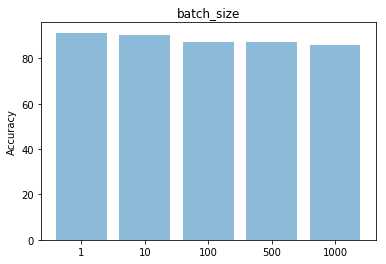

In [12]:
objects = batch_sizes
y_pos = numpy.arange(len(objects))
performance = batch_sizes_model_results

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('batch_size')

fig_batch_sizes = plt.gcf()
plt.show()
fig_batch_sizes.savefig('../images/ann_batch_sizes_mnist.png', dpi = 300)

#### Learning rate

##### Training

In [13]:
ann_learning_rates_list = []
learning_rates = [0.01, 0.1, 0.2, 0.4, 0.8]

for learning_rate in learning_rates:
    print("Learning_rates : ", learning_rate)
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)
    n.train(mnist_train_list)
    ann_learning_rates_list.append(n)

Learning_rates :  0.01
Training epoch#:  0
errors (SSE):  [4610.35940142]
Training epoch#:  1
errors (SSE):  [3855.13686905]
Training epoch#:  2
errors (SSE):  [3202.9229672]
Training epoch#:  3
errors (SSE):  [2662.96605917]
Training epoch#:  4
errors (SSE):  [2219.84312407]
Training epoch#:  5
errors (SSE):  [1869.58544669]
Training epoch#:  6
errors (SSE):  [1601.11336859]
Training epoch#:  7
errors (SSE):  [1403.48576322]
Training epoch#:  8
errors (SSE):  [1262.36904294]
Training epoch#:  9
errors (SSE):  [1161.98057947]
Training epoch#:  10
errors (SSE):  [1089.47839353]
Training epoch#:  11
errors (SSE):  [1035.861833]
Training epoch#:  12
errors (SSE):  [995.14879855]
Training epoch#:  13
errors (SSE):  [963.40527707]
Training epoch#:  14
errors (SSE):  [938.02424106]
Training epoch#:  15
errors (SSE):  [917.25081653]
Training epoch#:  16
errors (SSE):  [899.88126352]
Training epoch#:  17
errors (SSE):  [885.07348672]
Training epoch#:  18
errors (SSE):  [872.22693294]
Training 

errors (SSE):  [291.84683258]
Training epoch#:  61
errors (SSE):  [289.86215763]
Training epoch#:  62
errors (SSE):  [287.92690716]
Training epoch#:  63
errors (SSE):  [286.03905963]
Training epoch#:  64
errors (SSE):  [284.1967054]
Training epoch#:  65
errors (SSE):  [282.39803901]
Training epoch#:  66
errors (SSE):  [280.64135205]
Training epoch#:  67
errors (SSE):  [278.92502672]
Training epoch#:  68
errors (SSE):  [277.24752979]
Training epoch#:  69
errors (SSE):  [275.6074071]
Training epoch#:  70
errors (SSE):  [274.00327849]
Training epoch#:  71
errors (SSE):  [272.43383308]
Training epoch#:  72
errors (SSE):  [270.89782496]
Training epoch#:  73
errors (SSE):  [269.39406916]
Training epoch#:  74
errors (SSE):  [267.92143792]
Training epoch#:  75
errors (SSE):  [266.47885731]
Training epoch#:  76
errors (SSE):  [265.06530394]
Training epoch#:  77
errors (SSE):  [263.67980207]
Training epoch#:  78
errors (SSE):  [262.32142082]
Training epoch#:  79
errors (SSE):  [260.9892716]
Trai

errors (SSE):  [276.48257565]
Training epoch#:  22
errors (SSE):  [258.97210194]
Training epoch#:  23
errors (SSE):  [263.9918873]
Training epoch#:  24
errors (SSE):  [249.09551566]
Training epoch#:  25
errors (SSE):  [253.04000459]
Training epoch#:  26
errors (SSE):  [240.36560088]
Training epoch#:  27
errors (SSE):  [243.48573114]
Training epoch#:  28
errors (SSE):  [232.64414501]
Training epoch#:  29
errors (SSE):  [235.13219668]
Training epoch#:  30
errors (SSE):  [225.7928322]
Training epoch#:  31
errors (SSE):  [227.78556514]
Training epoch#:  32
errors (SSE):  [219.68396522]
Training epoch#:  33
errors (SSE):  [221.27596285]
Training epoch#:  34
errors (SSE):  [214.20580502]
Training epoch#:  35
errors (SSE):  [215.46266514]
Training epoch#:  36
errors (SSE):  [209.26362539]
Training epoch#:  37
errors (SSE):  [210.23216232]
Training epoch#:  38
errors (SSE):  [204.77839481]
Training epoch#:  39
errors (SSE):  [205.49376755]
Training epoch#:  40
errors (SSE):  [200.68456872]
Tra

errors (SSE):  [146.27308889]
Training epoch#:  83
errors (SSE):  [144.82276222]
Training epoch#:  84
errors (SSE):  [144.48271714]
Training epoch#:  85
errors (SSE):  [143.11612487]
Training epoch#:  86
errors (SSE):  [142.76196648]
Training epoch#:  87
errors (SSE):  [141.47221858]
Training epoch#:  88
errors (SSE):  [141.10579805]
Training epoch#:  89
errors (SSE):  [139.8865451]
Training epoch#:  90
errors (SSE):  [139.5096943]
Training epoch#:  91
errors (SSE):  [138.35507092]
Training epoch#:  92
errors (SSE):  [137.96959529]
Training epoch#:  93
errors (SSE):  [136.87417455]
Training epoch#:  94
errors (SSE):  [136.48184358]
Training epoch#:  95
errors (SSE):  [135.44060032]
Training epoch#:  96
errors (SSE):  [135.04313611]
Training epoch#:  97
errors (SSE):  [134.05141749]
Training epoch#:  98
errors (SSE):  [133.65048231]
Training epoch#:  99
errors (SSE):  [132.70398372]


##### Compute the accuracy of the neural networks

In [14]:
learning_rates_model_results = []
for model in ann_learning_rates_list: 
    correct = 0
    model.test(mnist_test_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    learning_rates_model_results.append(100 * (correct/len(model.results)))
    pass
pass

##### Show the accuracy of the neural networks

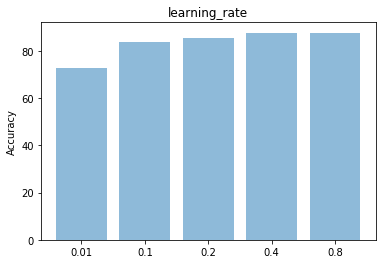

In [15]:
objects = learning_rates
y_pos = numpy.arange(len(objects))
performance = learning_rates_model_results

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('learning_rate')

fig_learning_rates = plt.gcf()
plt.show()
fig_learning_rates.savefig('../images/ann_learning_rates_mnist.png', dpi = 300)

## "Red and White Wine Quality EDA" dataset

### Loading file

In [9]:
wine_quality_file = open("../datasets/winequality-white.csv", 'r')
wine_quality_list = wine_quality_file.readlines()
wine_quality_file.close()

print("set size: ", len(wine_quality_list))

set size:  4899


### Normalize data

In [10]:
print(wine_quality_list[1])
"""
for entry in wine_quality_list:
    entry = ?
"""
print(wine_quality_list[1])

7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6

7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6



### Split data into *training set* and *testing set*

In [ ]:
random.shuffle(wine_quality_list)

wine_quality_train_list = wine_quality_list[:int(len(wine_quality_list) * .8)]
print("train set size: ", len(wine_quality_train_list))

wine_quality_test_list = wine_quality_list[int(len(wine_quality_list) * .8):] # why does it work ? should be 0.2 ! is there something I missed ? it's been 5 years I haven't used Python, mais quand même faut pas abuser...
print("test set size: ", len(wine_quality_test_list))

#### Epochs

##### Training

##### Compute the accuracy of the neural networks

##### Show the accuracy of the neural networks

#### Batch size

##### Training

##### Compute the accuracy of the neural networks

##### Show the accuracy of the neural networks

#### Learning rate

##### Training

##### Compute the accuracy of the neural networks

##### Show the accuracy of the neural networks